In [1]:
import hist
import numpy as np
import os
from pathlib import Path
import sys

In [2]:
current_dir = Path.cwd()
pikls = current_dir / 'pikls' / 'AN_plot_processor_UL'
src = current_dir.parent.parent / 'src'

sys.path.append(str(src))
sys.path.append(str(pikls))

from analysis_tools.plotting.efficiencies import calc_eff_err

In [3]:
pikls_to_open = []
for file in pikls.iterdir():
    print(file)
    pikls_to_open.append(file)

/home/cms-jovyan/dwg_experimental/notebooks/new_AN_plots/pikls/AN_plot_processor_UL/TChiWZ_UL.pkl
/home/cms-jovyan/dwg_experimental/notebooks/new_AN_plots/pikls/AN_plot_processor_UL/TTtoDiJet.pkl


In [4]:
pikls_to_open

[PosixPath('/home/cms-jovyan/dwg_experimental/notebooks/new_AN_plots/pikls/AN_plot_processor_UL/TChiWZ_UL.pkl'),
 PosixPath('/home/cms-jovyan/dwg_experimental/notebooks/new_AN_plots/pikls/AN_plot_processor_UL/TTtoDiJet.pkl')]

In [5]:
import cloudpickle

results = {}

for file in pikls_to_open:
    with open(file, "rb") as f:
        result = cloudpickle.load(f)
        for key, value in result.items():
            print(key)
            results[key]=value

SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL
TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL


In [6]:
results.keys()

dict_keys(['SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL', 'TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL'])

In [7]:
list(results.keys())[0]

'SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL'

In [8]:
r = results[list(results.keys())[0]]

In [9]:
r

{'total_entries': 5028190,
 'ele_dict': {'pt_eta_hist': Hist(
    Variable([2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
    Variable([0, 0.8, 1.442, 1.556, 2.5], name='eta'),
    IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
    IntCategory([-1, 1, 2, 3], name='qual_tag'),
    storage=Double()) # Sum: 3466618.0 (4082907.0 with flow),
  'pt_AN_hist_v1': Hist(
    Regular(40, 0, 100, name='pt'),
    IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
    IntCategory([-1, 1, 2, 3], name='qual_tag'),
    storage=Double()) # Sum: 4053276.0 (4082907.0 with flow),
  'pt_AN_hist_v2': Hist(
    Variable(array([  2. ,   3. ,   4. ,   5. ,   7. ,  10. ,  12.5,  15. ,  17.5,
          20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,
          42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,
          65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,
          87.5,  90. ,  92.5,  95. ,  97.5, 100. ]), name='pt'),
    IntCategory([-10, 10, 11, 12, 1

In [10]:
def make_plot_pt_ID(hist, title, num_events, sample_name, filename):
    plt.title(title, pad=35, fontsize=35)
    vmin = 0.0001
    vmax = 0.01
    

    # Normalize bin contents
    view = hist.view(flow=False)
    norm = view.sum()
    if norm > 0:
        hist.view(flow=False)[:] = view / norm  # overwrite in place

    mplhep.cms.label(loc=0, fontsize=20, com=13.6)
    plt.text(2.5, -0.8, f"numEvents = {num_events}", fontsize=15)
    plt.text(-0.5, 0, f"sample: {sample_name}", fontsize=13, rotation=90)
    
    #hist.plot2d(norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    hist.plot2d(norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    #hist.plot2d()

    plt.yticks(range(int(plt.ylim()[0]), int(plt.ylim()[1]) + 1, 2))
    plt.axhline(y=1.5, color='red', linestyle='--', linewidth=3)
    plt.savefig(filename)
    plt.show()

In [30]:
def make_plot_pt_ID_v2(ax, hist, title, num_events, sample_name, horz_lin):
    vmin = 0.0001
    vmax = 0.01

    # Normalize bin contents
    view = hist.view(flow=False)
    norm = view.sum()
    if norm > 0:
        hist.view(flow=False)[:] = view / norm  # overwrite in place

    mplhep.cms.label(loc=0, fontsize=22, com=13.6, ax=ax)
    ax.set_title(title, pad=35, fontsize=35)
    ax.set_xlabel('LowPtElectron $p_T$ (GeV)')
    ax.text(2, -0.8, f"numEvents = {num_events}", fontsize=16, fontweight="bold")
    ax.text(-1.8, 0, f"{sample_name}", fontsize=15, rotation=90, fontweight="bold")
    ax.set_xticks(range(0, 20, 5))

    # Ensure this ax is current for plot2d (in case plot2d uses plt.gca())
    plt.sca(ax)
    hist.plot2d(norm=colors.LogNorm(vmin=vmin, vmax=vmax), ax=ax)

    # Y ticks every 2 units
    y0, y1 = ax.get_ylim()
    ax.set_yticks(range(int(y0), int(y1) + 1, 2))

    ax.axhline(y=horz_lin, color='red', linestyle='--', linewidth=3)

In [12]:
def two_d_eff_err(h_num, h_denom): # h_num and h_denom must have same binning in both dimensions

    eff_h = h_num/h_denom # Creating a histogram
    
    err_h = np.sqrt(eff_h.values() * (1 - eff_h.values())/ h_denom.values())

    return eff_h, err_h

In [13]:
def plot_eta_pt_eff_v2(hist_num, hist_denom, title, source, sample_name="test", save_name="test", color="cividis", vmin=0, vmax=1, event_count=None):

    fig, ax = plt.subplots(figsize=(20, 20))
    mplhep.style.use(mplhep.style.CMS)
    mplhep.cms.label(loc=0, fontsize=28, com=13.6)

    eff = two_d_eff_err(hist_num, hist_denom)
    
    
    pt_edges = hist_num.axes[0].edges
    pt_centers = [(pt_edges[i] + pt_edges[i+1])/2 for i in range(len(pt_edges) - 1)]
    
    eta_edges = hist_num.axes[1].edges
    eta_centers = [(eta_edges[i] + eta_edges[i+1])/2 for i in range(len(eta_edges) - 1)]
    eta_labels = [fr"{eta_edges[i]:.3g} $< \eta \leq$ {eta_edges[i+1]:.3g}" for i in range(len(eta_edges) - 1)]
    
    
    #"viridis", "plasma", "inferno", "magma", "cividis"
    #plt.imshow(hist, aspect='auto', origin='lower', norm=colors.LogNorm())
    plt.imshow(
    eff[0],
    aspect='auto',
    cmap=color,
    origin='lower',
    extent=[eta_edges[0], eta_edges[-1], pt_edges[0], pt_edges[-1]],
    vmin=vmin,    # minimum value for color scale
    vmax=vmax     # maximum value for color scale
    )
    
    plt.xticks(ticks=eta_centers, labels=eta_labels, fontsize=30)
    plt.yticks(fontsize=35)

    # Get the efficiency values and errors
    values = np.nan_to_num(eff[0], nan=0.0)
    errors = np.nan_to_num(eff[1], nan=0.0)
    
    # Calculate bin centers for both axes
    

    # Loop through each bin and add text
    for i in range(len(pt_centers)):
        for j in range(len(eta_centers)):
            val = values[i, j]
            err = errors[i, j]
            plt.text(eta_centers[j], pt_centers[i], 
                    f"{val:.3f} ± {err:.3f}", 
                    ha='center', va='center', 
                    color='white', fontsize=25,
                    path_effects=[
                    path_effects.Stroke(linewidth=2, foreground='black'),
                    path_effects.Normal()
            ])
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tick_params(axis='x', pad=15)
    plt.tick_params(axis='y', pad=15)

    plt.ylabel("Electron $p_T$", fontsize=50)
    plt.title(f"Electron {title} Eff.", fontsize = 60, pad=60)

    
    plt.text(-0.3, pt_edges[3], f"Sample: {sample_name} {source}", ha='center', rotation=90, va='center', color='black', fontsize=35)
    if event_count is not None:
        plt.text(-0.17, pt_edges[3], f"num Events: {event_count}", ha='center', rotation=90, va='center', color='black', fontsize=30)

    plt.colorbar()
    plt.savefig(f"plots/{save_name}")
    plt.show()

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep
mplhep.style.use(mplhep.style.CMS)
plt.figure()
mplhep.style.use(mplhep.style.CMS)

<Figure size 1000x1000 with 0 Axes>

In [15]:
r.keys()

dict_keys(['total_entries', 'ele_dict', 'muon_dict', 'lpte_dict'])

In [16]:
r['lpte_dict']['pt_ID_hist']

Hist(
  Regular(20, 0, 20, name='pt'),
  Regular(100, 0, 10, name='ID'),
  IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
  IntCategory([-1, 1, 2, 3], name='qual_tag'),
  storage=Double()) # Sum: 3169061.0 (3573617.0 with flow)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f45f12c59d0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f45f18a5610>, text=[])

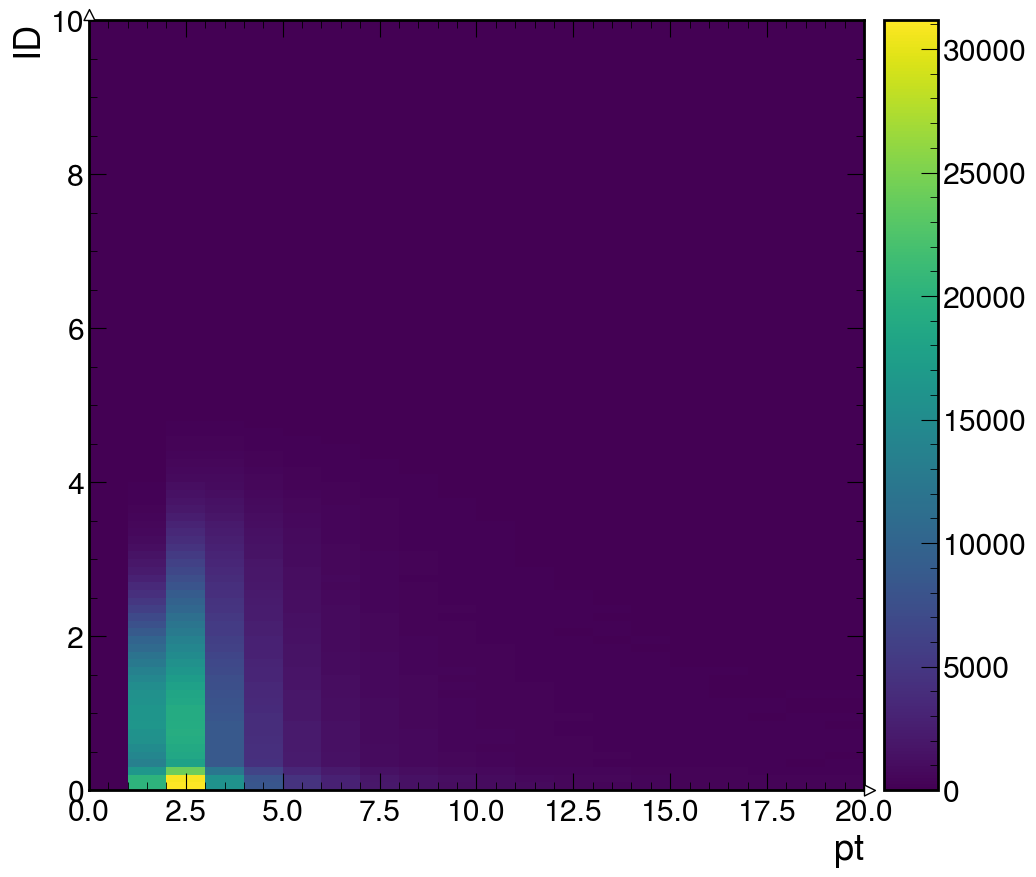

In [17]:
r['lpte_dict']['pt_ID_hist'].integrate("qual_tag")[:, :, 11j].plot()

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f4602755fd0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f45e87ef5c0>, text=[])

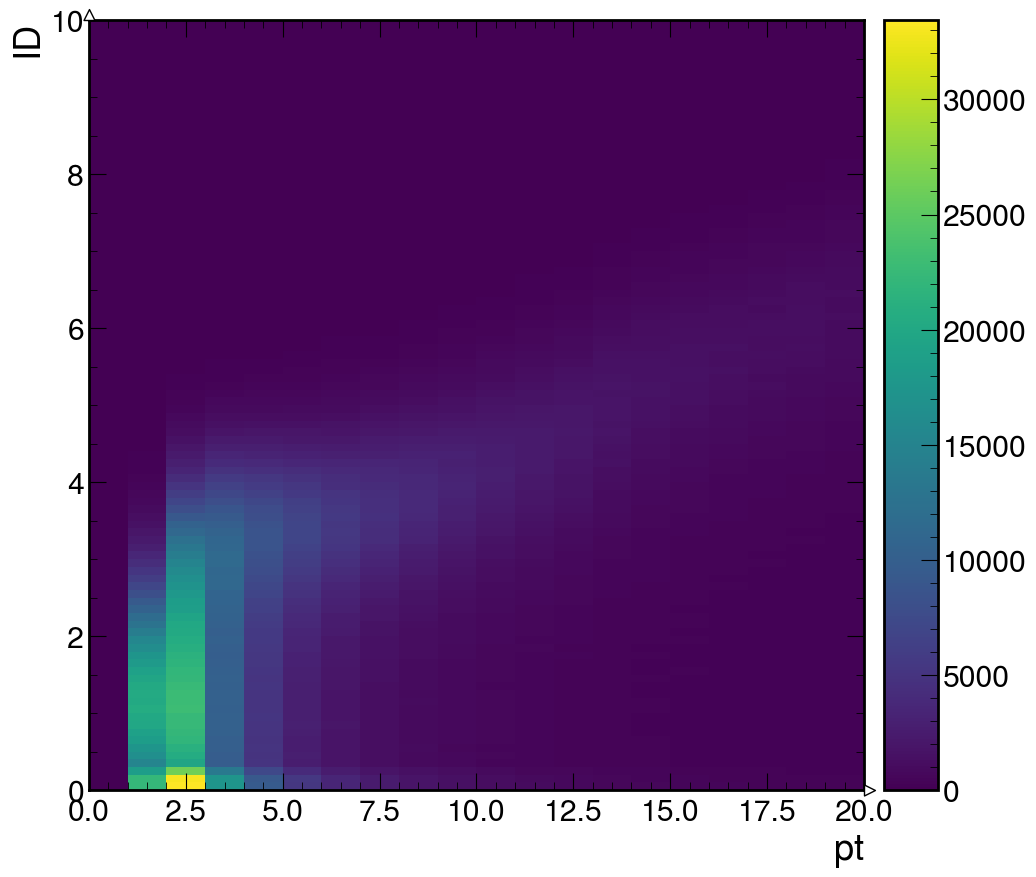

In [18]:
r['lpte_dict']['pt_ID_hist'].integrate("qual_tag").integrate("gen_tag").plot()


In [19]:
#make_plot_pt_ID_v2(ax, hist, title, num_events, sample_name, filename):

## 2023 SlepSnu270 vs ttbar

In [20]:
sig_name = list(results.keys())[0]
sig_name

'SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL'

In [21]:
bg_name = list(results.keys())[1]
bg_name

'TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL'

In [22]:
raw_signal_lpte_pt_ID = (
    results[sig_name]['lpte_dict']['pt_ID_hist'].integrate("qual_tag")[:,:, 10j]
)

In [23]:
raw_background_lpte_pt_ID = (
    results[bg_name]['lpte_dict']['pt_ID_hist'].integrate("qual_tag")[:,:, 11j]
)

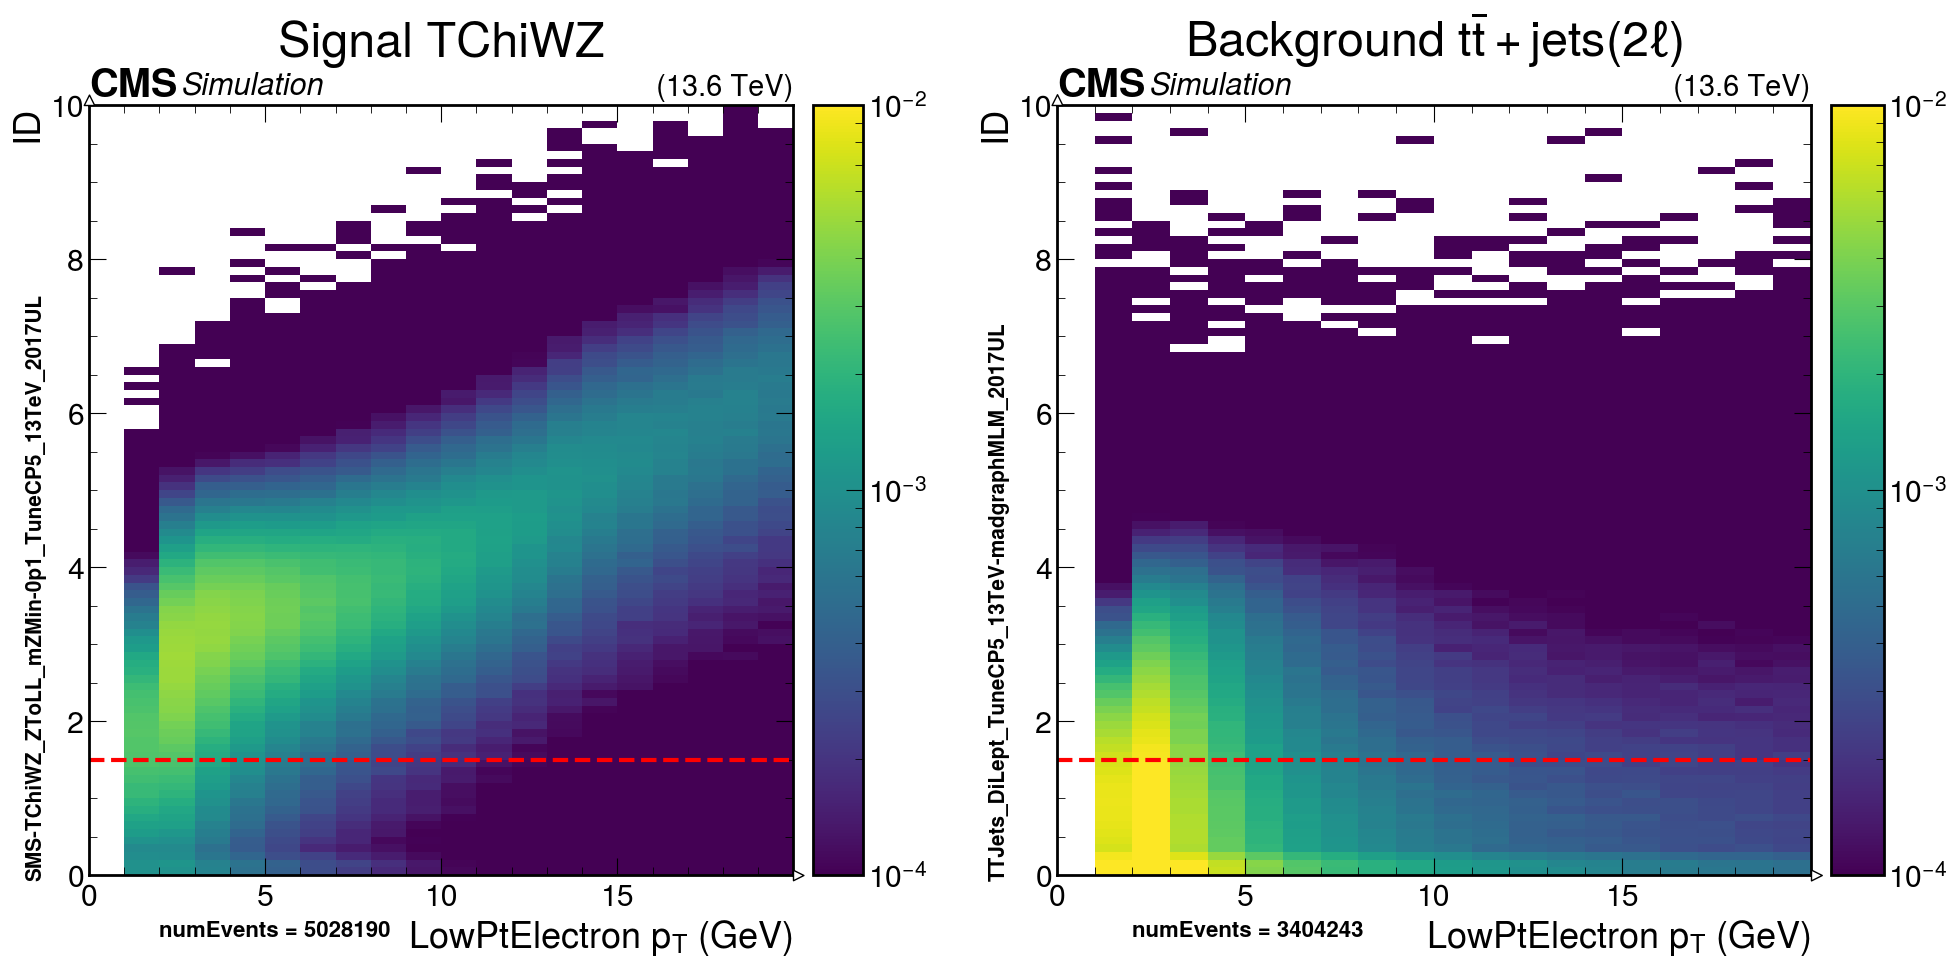

In [37]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

make_plot_pt_ID_v2(
    axes[0],
    raw_signal_lpte_pt_ID,
    "Signal TChiWZ",
    results[sig_name]['total_entries'],
    sig_name[:40]+ "_2017UL",
    horz_lin=1.5
)

make_plot_pt_ID_v2(
    axes[1],
    raw_background_lpte_pt_ID,
    r"Background $t\overline{t}+jets(2\ell)$",
    results[bg_name]['total_entries'],
    bg_name[:39]+"_2017UL",
    horz_lin=1.5
)

fig.savefig('ID_vs_pt_signal_vs_background_17UL.pdf')